In [1]:

import pickle
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import joblib



In [2]:
returns = pd.read_csv("availability_hourly.csv")
tss = TimeSeriesSplit(n_splits=5, test_size=24*60, gap=24)
df = returns.sort_values(by=['end_time_year', 'end_time_month', 
                            'end_time_day', 'end_time_hour'])
df = df.drop(columns=['Unnamed: 0', 'duration_sec']).reset_index(drop=True)

standard_stations = pd.read_csv("stations_with_clusters.csv")
weather_data = pd.read_csv("weather_data.csv")

df = df.merge(standard_stations[['station_name', 'clusters']].rename(columns={
    "station_name":'end_station_name'}), on=["end_station_name"])

df = df[df.groupby('end_station_name')['end_station_name'].transform('size') >= 1000]

latest_trips = df.groupby('end_station_name').nth(-1)
earliest_trips = df.groupby('end_station_name').nth(0)


recently_operational_stations = latest_trips[(latest_trips['end_time_year'] == 2022) & 
                                             (latest_trips['end_time_month'] >= 8)].index

stations_operational_since_2021 = earliest_trips[(earliest_trips['end_time_year'] == 2021)].index
df = df[df['end_station_name'].isin(stations_operational_since_2021)].reset_index(drop=True)

column_name = "end_time"
conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day'],
                           hour=  df[f'{column_name}_hour']
                        )
df['time'] = pd.to_datetime(conversion_dict_daily).astype(str)

df = df.merge(weather_data[['temp', 'dwpt', "rhum", "prcp", "wdir", 
                            "wspd", "pres", "coco", "centroid", 'time']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "time"])

df.loc[df['prcp'].isna(), 'prcp'] = 0.0
df.loc[df['pres'].isna(), 'pres'] = df['pres'].median()
df.loc[df['coco'].isna(), 'coco'] = df['coco'].mode()[0]

In [3]:
def add_lags(df, target, identifier):
    df_res = pd.DataFrame()
    print(target)
    for ii in df[identifier].unique():
        df_current = df[df["end_station_name"]==ii]
        df_current.index = df_current['time']
        df_current.index = pd.to_datetime(df_current.index)
        target_map = df_current[target].to_dict()
        df_current[f"{target}_lag_1_h"] = (df_current.index - pd.Timedelta('1 hours')).map(target_map)
        df_current[f"{target}_lag_2_h"] = (df_current.index - pd.Timedelta('2 hours')).map(target_map)
        df_current[f"{target}_lag_24_h"] = (df_current.index - pd.Timedelta('24 hours')).map(target_map)
        if target == "demand" or target == "bike_return":
            df_current[f"{target}_lag_1_h"] = df_current[f"{target}_lag_1_h"].fillna(0)
            df_current[f"{target}_lag_2_h"] = df_current[f"{target}_lag_2_h"].fillna(0)
            df_current[f"{target}_lag_24_h"] = df_current[f"{target}_lag_24_h"].fillna(0)
        else:
            df_current[f"{target}_lag_1_h"] = df_current[f"{target}_lag_1_h"].interpolate().fillna(0)
            df_current[f"{target}_lag_2_h"] = df_current[f"{target}_lag_2_h"].interpolate().fillna(0)
            df_current[f"{target}_lag_24_h"] = df_current[f"{target}_lag_24_h"].interpolate().fillna(0)
        df_res = df_res.append(df_current)
    return df_res

In [4]:
df = add_lags(df, "bike_return", identifier='end_station_name')
df = add_lags(df, "temp", identifier='end_station_name')
df = add_lags(df, "prcp", identifier='end_station_name')
df = add_lags(df, "rhum", identifier='end_station_name')
df = add_lags(df, "wspd", identifier='end_station_name')

df = df.sort_values(by=['end_time_year', 'end_time_month', 
                        'end_time_day', 'end_time_hour']).drop(
    columns=['time']).reset_index(drop=True)

bike_return


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

temp


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

prcp
rhum
wspd


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923065 entries, 0 to 1923064
Data columns (total 34 columns):
 #   Column                Dtype  
---  ------                -----  
 0   end_station_name      object 
 1   end_time_year         int64  
 2   end_time_month        int64  
 3   end_time_day          int64  
 4   end_time_hour         int64  
 5   bike_return           int64  
 6   end_time_week         int64  
 7   end_time_quarter      int64  
 8   end_time_dayofweek    int64  
 9   is_holiday            bool   
 10  clusters              int64  
 11  temp                  float64
 12  dwpt                  float64
 13  rhum                  float64
 14  prcp                  float64
 15  wdir                  float64
 16  wspd                  float64
 17  pres                  float64
 18  coco                  float64
 19  bike_return_lag_1_h   float64
 20  bike_return_lag_2_h   float64
 21  bike_return_lag_24_h  float64
 22  temp_lag_1_h          float64
 23  temp_la

In [6]:
for i in df.columns:
    print(i)
    print(sum(df[i].isna()))

end_station_name
0
end_time_year
0
end_time_month
0
end_time_day
0
end_time_hour
0
bike_return
0
end_time_week
0
end_time_quarter
0
end_time_dayofweek
0
is_holiday
0
clusters
0
temp
0
dwpt
0
rhum
0
prcp
0
wdir
0
wspd
0
pres
0
coco
0
bike_return_lag_1_h
0
bike_return_lag_2_h
0
bike_return_lag_24_h
0
temp_lag_1_h
0
temp_lag_2_h
0
temp_lag_24_h
0
prcp_lag_1_h
0
prcp_lag_2_h
0
prcp_lag_24_h
0
rhum_lag_1_h
0
rhum_lag_2_h
0
rhum_lag_24_h
0
wspd_lag_1_h
0
wspd_lag_2_h
0
wspd_lag_24_h
0


In [7]:
del returns

In [8]:
df.tail()

,end_station_name,end_time_year,end_time_month,end_time_day,end_time_hour,bike_return,end_time_week,end_time_quarter,end_time_dayofweek,is_holiday,...,temp_lag_24_h,prcp_lag_1_h,prcp_lag_2_h,prcp_lag_24_h,rhum_lag_1_h,rhum_lag_2_h,rhum_lag_24_h,wspd_lag_1_h,wspd_lag_2_h,wspd_lag_24_h
1923060,Folsom St at Main St,2023,1,1,0,9,52,1,6,True,...,12.100000,3.5,0.0,2.25,86.000000,58.142857,72.000000,27.700000,29.442857,14.800000
1923061,Broadway at Kearny St,2023,1,1,0,1,52,1,6,True,...,17.900000,0.0,0.0,0.00,86.571429,71.318182,72.444444,15.314286,17.231818,26.744444
1923062,Montgomery St BART Station (Market St at 2nd St),2023,1,1,0,1,52,1,6,True,...,9.233333,0.0,13.9,0.00,54.800000,89.000000,85.666667,2.960000,24.100000,5.066667
1923063,7th Ave at Lawton St,2023,1,1,0,1,52,1,6,True,...,15.327273,0.0,0.0,0.00,86.000000,53.714286,69.272727,13.000000,4.628571,19.531818
1923064,North Point St at Powell St,2023,1,1,0,2,52,1,6,True,...,11.700000,0.0,13.9,0.00,87.200000,89.000000,62.250000,10.360000,24.100000,10.825000


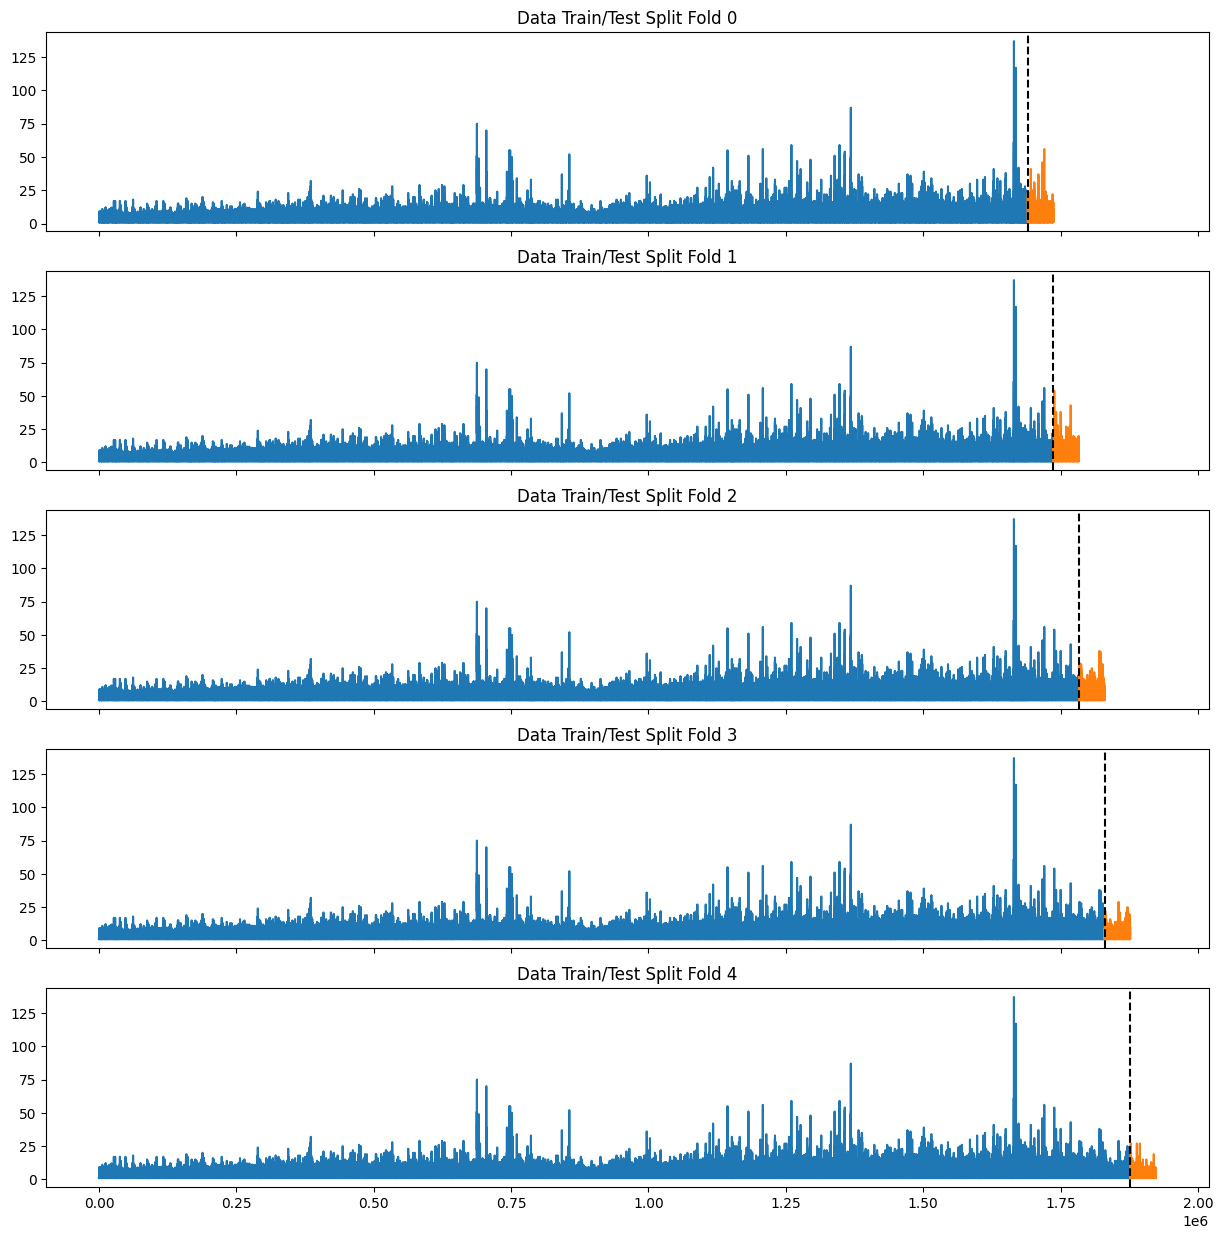

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['end_station_name'].nunique(), gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['bike_return'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['bike_return'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [10]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['end_station_name'].nunique(), gap=24)
df = df.sort_index()

fold = 0
preds = pd.DataFrame()
rmse = []
mape = []
le = preprocessing.LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))
SCALER_FEATURES = ["end_time_year", "end_time_month", 
                   "end_time_day",  "end_time_hour", 
                   "end_time_week", "end_time_quarter",
                   "end_time_dayofweek",
                   "temp", "dwpt", "rhum", "prcp", "wdir",
                   "wspd", "pres","coco",
                   "bike_return_lag_1_h", "bike_return_lag_2_h", 
                   "bike_return_lag_24_h", "temp_lag_1_h", 
                   "temp_lag_2_h", "temp_lag_24_h",
                   "prcp_lag_1_h", "prcp_lag_2_h",
                   "prcp_lag_24_h", "rhum_lag_1_h",
                   "rhum_lag_2_h", "rhum_lag_24_h", "wspd_lag_1_h", 
                   "wspd_lag_2_h","wspd_lag_24_h"]
target_scaler = MinMaxScaler(feature_range=(1, 2))
df[SCALER_FEATURES] = scaler.fit_transform(df[SCALER_FEATURES])
df[['bike_return']] = target_scaler.fit_transform(df[['bike_return']])
df['end_station_name'] = le.fit_transform(df['end_station_name'])
df['is_holiday'] = df['is_holiday'].astype(int)


In [11]:
24*10*df['end_station_name'].nunique()

93120

In [12]:

for train_idx, val_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    FEATURES = ["end_station_name", 
                "end_time_year",
                "end_time_month",
                "end_time_day",
                "end_time_hour",
                "end_time_week",
                "end_time_quarter",
                "end_time_dayofweek",
                "is_holiday",
                "clusters",
                "temp",
                "dwpt",
                "rhum",
                "prcp",
                "wdir",
                "wspd",
                "pres",
                "coco",
                "bike_return_lag_1_h",
                "bike_return_lag_2_h",
                "bike_return_lag_24_h",
                "temp_lag_1_h",
                "temp_lag_2_h",
                "temp_lag_24_h",
                "prcp_lag_1_h",
                "prcp_lag_2_h",
                "prcp_lag_24_h",
                "rhum_lag_1_h",
                "rhum_lag_2_h",
                "rhum_lag_24_h",
                "wspd_lag_1_h",
                "wspd_lag_2_h",
                "wspd_lag_24_h"
                ]
    TARGET = 'bike_return'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    preds_out = X_test.copy()
    preds_out['actual_returns'] = y_test
    preds_out['pred'] = y_pred
    preds = preds.append(preds_out)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)
    rmse.append(rmse_score)
    mape.append(mape_score)
    print(rmse_score)
    print(mape_score)
    print(preds.head())
    print(preds.tail())
    
print(f"Mean RMSE: {np.mean(rmse)}")
print(f"Mean MAPE: {np.mean(mape)}")
del df
del X_train
del y_train
del X_test

0.011966958229687645
0.00795016861271226
         end_station_name  end_time_year  end_time_month  end_time_day  \
1690265               292            1.5        1.818182      1.033333   
1690266               350            1.5        1.818182      1.033333   
1690267               363            1.5        1.818182      1.033333   
1690268               369            1.5        1.818182      1.033333   
1690269               247            1.5        1.818182      1.033333   

         end_time_hour  end_time_week  end_time_quarter  end_time_dayofweek  \
1690265       1.521739       1.730769               2.0                 2.0   
1690266       1.521739       1.730769               2.0                 2.0   
1690267       1.521739       1.730769               2.0                 2.0   
1690268       1.521739       1.730769               2.0                 2.0   
1690269       1.521739       1.730769               2.0                 2.0   

         is_holiday  clusters  ...  prc

0.01075631589617973
0.007403081842657956
         end_station_name  end_time_year  end_time_month  end_time_day  \
1690265               292            1.5        1.818182      1.033333   
1690266               350            1.5        1.818182      1.033333   
1690267               363            1.5        1.818182      1.033333   
1690268               369            1.5        1.818182      1.033333   
1690269               247            1.5        1.818182      1.033333   

         end_time_hour  end_time_week  end_time_quarter  end_time_dayofweek  \
1690265       1.521739       1.730769               2.0                 2.0   
1690266       1.521739       1.730769               2.0                 2.0   
1690267       1.521739       1.730769               2.0                 2.0   
1690268       1.521739       1.730769               2.0                 2.0   
1690269       1.521739       1.730769               2.0                 2.0   

         is_holiday  clusters  ...  prc

0.008911150772146227
0.00654756359711912
         end_station_name  end_time_year  end_time_month  end_time_day  \
1690265               292            1.5        1.818182      1.033333   
1690266               350            1.5        1.818182      1.033333   
1690267               363            1.5        1.818182      1.033333   
1690268               369            1.5        1.818182      1.033333   
1690269               247            1.5        1.818182      1.033333   

         end_time_hour  end_time_week  end_time_quarter  end_time_dayofweek  \
1690265       1.521739       1.730769               2.0                 2.0   
1690266       1.521739       1.730769               2.0                 2.0   
1690267       1.521739       1.730769               2.0                 2.0   
1690268       1.521739       1.730769               2.0                 2.0   
1690269       1.521739       1.730769               2.0                 2.0   

         is_holiday  clusters  ...  prc

In [13]:
suf = "returns_Dec_2022_weather_lags"

preds.to_csv(f"test_predictions{suf}.csv")
del preds

filename = f'returns_model{suf}.sav'
joblib.dump(reg, filename)
del reg

filename = f'target_scaler{suf}.sav'
joblib.dump(target_scaler, filename)
del target_scaler

filename = f'scaler{suf}.sav'
joblib.dump(scaler, filename)
del scaler

filename = f'label_encoder{suf}.sav'
joblib.dump(le, filename)
del le


In [14]:
#preds['demand'] = preds['actual_demand']
#preds[SCALER_FEATURES] = scaler.inverse_transform(preds[SCALER_FEATURES])